In [1]:
import pandas as pd
import re
import os
import sys
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from mice_inspection_utils import *


imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_9744/3874384173.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
directory = "new_outputs_miriam"
os.makedirs(directory, exist_ok = True)

### How reliable is our data

OTUs come with a % confidence score on the species assignation. Every read will map to a different OTU, this is why there are more OTUs than species.
We would like to discard OTUs that have a low confidence on the species. But how 
The unique identifier of an OTU is the SEQUENCE ??


% id,alignment length,mismatches,gap openings,e-value,bit score,coverage,sequence


Let's see how many samples have a confidence level > ( 1 - threshold ), for threshold values ranging in [0, 1]. 

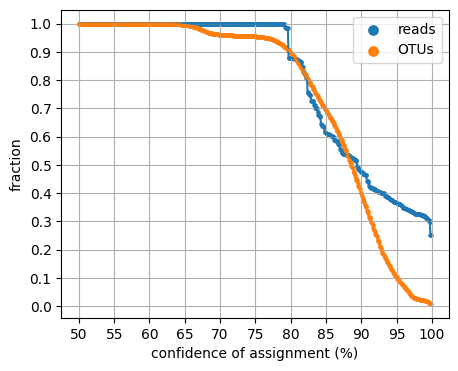

In [47]:
metadata_df = pd.read_csv(metadata_path)
df = metadata_df[["query", "total_reads", "% id"]]
df.head()
total_ = df["total_reads"].sum()
total_otus = len(df)

thresholds = np.arange(50, 100, 0.1)
reads_fraction = np.zeros(len(thresholds))
otus_fraction = np.zeros(len(thresholds))

for i, t in enumerate(thresholds):
    reads_fraction[i] = df[df["% id"] > t]["total_reads"].sum() / total_
    otus_fraction[i] = len(df[df["% id"] > t]["total_reads"]) / total_otus


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
ax.scatter(thresholds, reads_fraction, s = 5, label = "reads")
ax.plot(thresholds, reads_fraction)
ax.grid(which = "both")
ax.set_xlabel("confidence of assignment (%)")
ax.set_ylabel("fraction")
ax.set_xticks(np.arange(50, 101, 5))
ax.set_yticks(np.arange(0, 1.1, 0.1))
#ax.set_xticklabels(np.arange(0, 1.1, 0.1))

ax.scatter(thresholds, otus_fraction, s = 5, label = "OTUs")
ax.plot(thresholds, otus_fraction)
ax.legend(markerscale = 3)

output_path = os.path.join(directory, "assignment_confidence.png")
plt.savefig(output_path)

Comments: clearly we should forget about the typical confidence levels used in physics. With a Cl of 95%, for instance, we would discard over 60% of the reads!

A reasonable choice could be a CL 0f 80%... Still, pretty low for a physicist's standard. We should keep in mind for all subsequent analysis that this is the data we work with.

#### Looking at time series: testing the null hypotesis of stationarity.



Before going on with the stochastic logistic model, we should - at least -  test the null hypotesis of stationarity. Two main tests can be used:

- The augmented dickey-fuller (ADF) test: models the time series as an autoregressive model of order p-th and checks if its is stationary by analyzing the roots of the poli

- KPSS test: decomposes as moving average plus white noise. checks if this moving average is constant.

### Analyis of correlograms (the sample ACF)

In a stationary process, we expect ACF(k) to eventually settle to zero as the lag k increases - either abruptly, or in an oscillating fashion, or exponentially like, or with some other trend, depending on the underlying process.

When looking at correlograms, we can already perform a statistic test on the null hypotesis that the series is **pure white noise**. Individual sample autocorrelations would be approximately distributed with mean zero and variance 1/T under the hypotesis that the series is white noise.

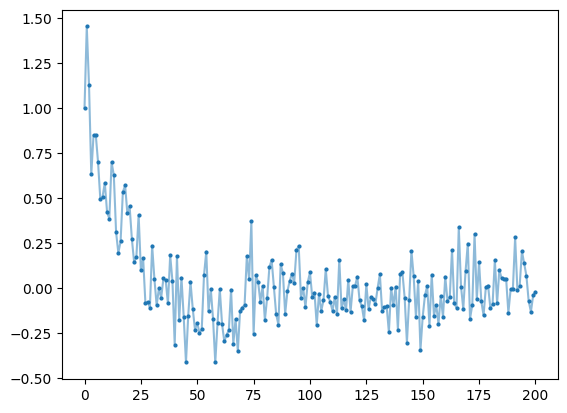

In [3]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf



df = pd.read_csv("Data/by_mouse_transposed/mouse_1_transposed.csv")
times = df["day"].to_numpy(dtype=int)
counts = df["Prevotella sp. Smarlab 121567"].copy()#.to_numpy(dtype=int)

lag_max = 200
acf_, confint, qstat, pvalues = acf(x = counts, nlags = lag_max, qstat = True, adjusted = True, alpha = .05, missing = "conservative")

plt.plot(np.arange(0, lag_max + 1), acf_, alpha = 0.5)
plt.scatter(np.arange(0, lag_max + 1), acf_, s = 4)
#plt.shade_between(x = np.arange(0, lag_max + 1), ymin = acf - confint[])
#plot_acf(x = counts, adjusted = True, lags = 100, missing = "conservative")

In [5]:
# Anatomy of stattools.acovf
# Super nice code! 
# My own attempt was a mess with respect to this
# A reminder to always use pre-built functions when available!

#x = np.array([1, np.nan, 2, 3,5,6,np.nan])


def acf_with_missing(y):
    x = y.copy()
    notmask_bool = ~np.isnan(x)  # bool
    notmask_int = notmask_bool.astype(int) # zeros for nan
    # Must copy for thread safety
    x[~notmask_bool] = 0
    #print(x)
    #print(notmask_int)
    xo = x - x.sum() / notmask_int.sum()
    xo[~notmask_bool] = 0
    #print(xo)

    n = len(x)
    # compute number of valid pairs
    d = np.correlate(notmask_int, notmask_int, "full")
    #print("lags:", np.arange(0, len(d)) - (n-1))
    #print(d)
    # only consider positive lags:
    print("lags:", np.arange(n-1, len(d))- (n-1))
    print(d[n-1 :])
    valid_pairs = d[n - 1 :] != 0
    d[d == 0] = 1
    acov = np.correlate(xo, xo, "full")[n - 1 :] / d[n - 1 :]
    acov[~valid_pairs] = np.nan
    #print(acov)
    return acov

#acov = acf_with_missing(x)

lags: [0 1 2 3 4 5 6 7 8]
[6 3 3 3 2 2 1 0 1]


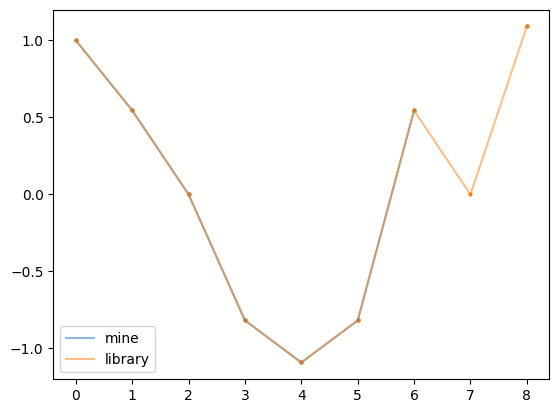

In [8]:
x = np.array([1, np.nan, 2, 3,5,6,np.nan, np.nan, 1])
#x = counts.to_numpy()
lag_max = len(x)

acov = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")


lag_max_plot = min(lag_max, 10)
plt.plot(np.arange(0, lag_max_plot), acov[0:lag_max_plot]/acov[0], alpha = 0.5,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acov[0: lag_max_plot]/acov[0], s = 4)
plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
plt.legend()

lags: [   0    1    2 ... 1041 1042 1043]
[217  22  26 ...   0   0   1]


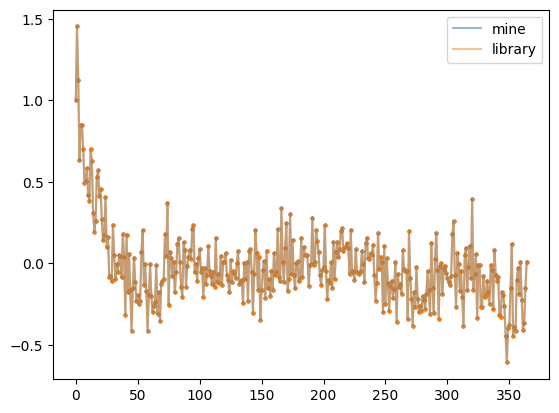

In [9]:
#x = np.array([1, np.nan, 2, 3,5,6,np.nan, np.nan, 1])
x = counts.to_numpy()
lag_max = len(x)

acov = acf_with_missing(x)


acf_ = acf(x, nlags= lag_max, adjusted = True, missing = "conservative")


lag_max_plot = 365
plt.plot(np.arange(0, lag_max_plot), acov[0:lag_max_plot]/acov[0], alpha = 0.5,label = "mine")
plt.scatter(np.arange(0, lag_max_plot), acov[0: lag_max_plot]/acov[0], s = 4)
plt.plot(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], alpha = 0.5, label = "library")
plt.scatter(np.arange(0, lag_max_plot), acf_[0: lag_max_plot], s = 4)
plt.legend()


Riassunto: la funzione pre-built di statstools fa quello che deve, con l'unico difetto che però non distingue nell output finale le correlazioni che sono 0. perchè non c'erano coppie valide su cui calcolarle (e che quindi dovrebbero essere dei nan a rigore) dagli zeri "reali".

Ora devo stimare gli errori e capire cos'è il test di Lijung-Box per l'ipotesi nulla di white noise.



Rispetto agli errori, leggo da statsmodels:


bartlett_confint : bool, default True
Confidence intervals for ACF values are generally placed at 2 standard errors around r_k. The formula used for standard error depends upon the situation. If the autocorrelations are being used to test for randomness of residuals as part of the ARIMA routine, the standard errors are determined assuming the residuals are white noise. The approximate formula for any lag is that standard error of each r_k = 1/sqrt(N). See section 9.4 of [2] for more details on the 1/sqrt(N) result. For more elementary discussion, see section 5.3.2 in [3]. For the ACF of raw data, the standard error at a lag k is found as if the right model was an MA(k-1). This allows the possible interpretation that if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. In this case, a moving average model is assumed for the data and the standard errors for the confidence intervals should be generated using Bartlett's formula. For more details on Bartlett formula result, see section 7.2 in [2]




/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_4242/2320998947.py:43: RuntimeWarning: invalid value encountered in scalar divide
  pearson = sum /( n * (std ** 2))


Text(0, 0.5, 'autocorrelation')

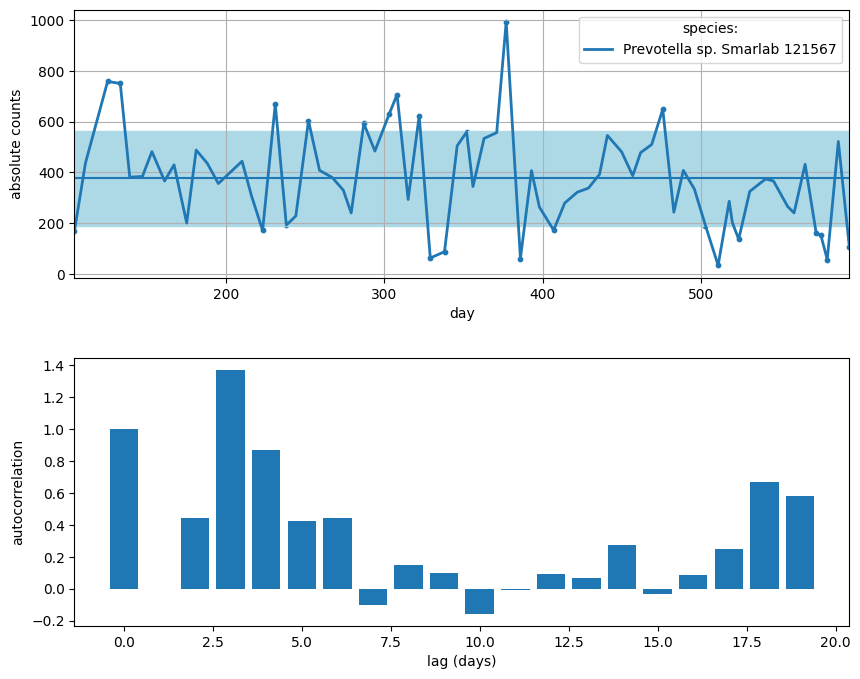

In [10]:
# TODO what is the statistical uncertainty associated to my estimate of the autocorrelation function ACF(T) ?
# There should be some error, because the series is not infinite, therefore, smaller lags get a number of samples
# that is bigger. (the ACF at lag T=2 is estimated over a number of samples that is bigger than the number of samples
# used to estimate lag=20).

slot = (100, 600) # consider subset of timeseries without the initial transient
species_to_examine = ["Aureibacter tunicatorum", "Candidatus Prevotella conceptionensis", "Vibrio cholerae"]

species = "Prevotella sp. Smarlab 121567"
#rank = 29 # species which we examine


df = pd.read_csv(f"Data/by_mouse/mouse_1.csv")

rank = df.index[df["species"] == species].tolist()[0] # find index of row containing "Vibrio cholerae"

times = df.columns[4:].to_numpy(dtype=int)
counts = df.iloc[rank, 4:].to_numpy(dtype=int)


initial_day = slot[0]
final_day = slot[1]
tuple = (np.where(times >= initial_day)[0][0], np.where(times <= final_day)[0][-1]) 


times = times[tuple[0]:tuple[1]]
counts = counts[tuple[0]:tuple[1]]
#counts = df.iloc[rank, 4:].to_numpy(dtype=int)

std = np.std(counts)
mean = np.mean(counts)


data = []
for lag in range(0, 20):
    sum = 0
    n = 0
    for i, time in enumerate(times):
        for j in range(i, len(times)):
            if times[j] == time + lag:
                n += 1
                sum += (counts[i] - mean) * (counts[j] - mean)
    pearson = sum /( n * (std ** 2))
    data.append({'lag': lag, 'pearson': pearson})

results = pd.DataFrame(data)
#results.to_csv("Inspection_Outputs/prova_ACF.csv")


fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,8))
plt.subplots_adjust(hspace = 0.3)
ax1.plot(times, counts, label = f"{df.iloc[rank, 1]}", linewidth = 2) #, color = colors(rank % 10))
ax1.scatter(times, counts, s= 10)#, color = colors(rank % 10))
ax1.axhline(y= mean)#, color = colors(rank % 10))
ax1.fill_between(x=times, y1=mean - std, y2=mean + std, color = "lightblue")#, color=colors(rank % 10), alpha=0.5)
ax1.legend(title = "species:",
                loc= "upper right")
ax1.set_xlim(min(times), max(times))
#ax1.set_xticks([t for i, t in enumerate(times) if i % 20 == 0])
ax1.grid()
ax1.set_xlabel("day")
ax1.set_ylabel("absolute counts")
ax2.bar(results['lag'], results['pearson'])#, color=colors(rank % 10))
ax2.set_xlabel("lag (days)")
ax2.set_ylabel("autocorrelation")

#plt.savefig(f"Inspection_Outputs/ACF_mouse_1_species_{species}.pdf")

NULL hypotesis: the series is non- stationary (has unit root)

Alternative hypotesis: the series is stationary

Results of Dickey-Fuller Test:
Test Statistic                   -3.711161
p-value                           0.003959
#Lags Used                       20.000000
Number of Observations Used    1024.000000
Critical Value (1%)              -3.436752
Critical Value (5%)              -2.864367
Critical Value (10%)             -2.568275
dtype: float64


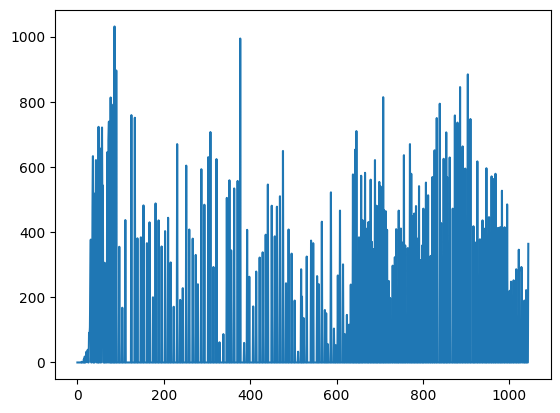

In [9]:
df = pd.read_csv("Data/by_species/Prevotella sp. Smarlab 121567.csv")
series = df["mouse_1"].copy()
series.head()

series.plot()


from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(series)

pvalue < 0.05. Null hypotesis is rejected. 

The series is believed to be STATIONARY